# <b>Modeling: Satirical and Fake News Classification</b>
#### <font color = 'gray'>Christine Gregg | December 2022</font>

###<b>Imports & Constants</b>

In [1]:
!pip install scattertext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import string
from collections import Counter
from scipy import sparse
import matplotlib.pyplot as plt
import altair as alt
import scattertext as st

import nltk
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier


# Constants
RANDOM_STATE = 42
GOLBECK_PATH = 'data\processed\satire_fake\full_golbeck_df'
CLASS_MAP = {'Fake': 0, 'Satire': 1, 'Real': 2}
POS_LABEL = 'Satire'
RED = '#D62728'
BLUE = '#1F77B4'
PUNCTUATION = '.,-?!:;"'
MIN_DF = 2
MAX_DF = 0.5


# # If running in Colab: connecting to Shared Google Drive
# # Run this cell and select your UMich Google account in the pop-up
# from google.colab import drive
# import sys
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###<b>Function Definitions</b>

In [43]:
def count_punctuation(text_df):
    """
    Counts the occurrences of each punctuation type in the provided text.

    Args:
        text_df (DataFrame): The DataFrame with the column 'text' for processing.
    Returns:
        text_punct_df (DataFrame): The provided DataFrame with columns
            containing punctuation counts by type, normalized by article length.
    """
    drop_cols=['article_id', 'title', 'text']

    clean_df = text_df.fillna(' ')

    clean_df['punct_dict'] = clean_df.text.apply(
        lambda s: {
            k:(v/len(s)) for k, v in Counter(s).items() if k in PUNCTUATION
            }
        )

    text_punct_df = pd.concat(
        [clean_df, clean_df.punct_dict.apply(pd.Series)], axis=1
        ).drop(
            'punct_dict',axis=1
            )

    # Unused punctuation types will appear as NaN - set to zero
    text_punct_df.fillna(0, inplace=True)

    # Return only punctuation columns
    return text_punct_df.drop(drop_cols, axis=1)


def merge_features(X_vectorized, X_to_transform):
    """
    Converts numeric features to sparse matrix and scales, then merges with the 
    existing vectorized text matrix.

    Args:
        X_vectorized (sparse matrix): The vectorized text sparse matrix.
        X_to_transform (DataFrame): A DataFrame of numeric features to 
            transform and scale.
    Returns:
        [Unnamed]: The merged sparse matrix of all features.
    """
    tempArray = sparse.csr_matrix(X_to_transform.values)
    tempScaler = preprocessing.MaxAbsScaler().fit(tempArray)
    tempArray = tempScaler.transform(tempArray)

    # Merge the two sparse arrays
    return sparse.hstack([X_vectorized, tempArray])


def get_model_scores(y_labels, y_preds, label=POS_LABEL):
    """
    Prints sklearn classification report and overall model accuracy and F1 score.

    Args:
        y_labels (list or Series): Actual labels.
        y_preds (list or Series): Predicted labels.
        pos_label (str): The label to use as the positive class for computation.
    Returns:
        None (in line print only)
    """
    f1 = f1_score(y_labels, y_preds, pos_label=label, zero_division=0)
    acc = accuracy_score(y_labels, y_preds)
    
    print('CLASSIFICATION REPORT:\n')
    print(classification_report(y_labels, y_preds, zero_division=0))

    print(
        f'\nOVERALL MODEL SCORES:\nF1 Score: {f1}\nAccuracy: {acc}'
        )


def plot_confusion_matrix(y_test=None, y_pred=None, labels=None):
    """
    Plots the confusion matrix for the given model results (in line plot).

    Args:
        y_test (list or series): Real labels for the test dataset.
        y_pred (list or series): Predicted labels for the test dataset.
        labels (list): Classification label names.
    Returns:
        None
    """
    conf_matrix = confusion_matrix(
        y_test, y_pred, 
        labels=labels, 
        normalize='all'
        )
    cm_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    cm_disp.plot(cmap='Purples')
    print('\n')
    plt.show()


def explain_pred(features, train_array, clf_lr, num_top_feats=20):
    """
    Creates a lime-like horizontal bar chart showing feature importance.

    Args:
        features (list): A list of features names as strings.
        train_array (array): The vectorized training array.
        clf_lr (model): The trained logistic regression model.
        num_top_feats (int): Number of top features to include in chart.
    Returns:
        weights_df (DataFrame): A DataFrame of LR weights by term.
        final_chart (plot): Prints a horizontal bar chart showing the most 
            important features across each class in line.
    """
    domain_color = ['Satire', 'Fake']
    range_color = [BLUE, RED]

    # Standardized list of Logistic Regression model coefficients
    lr_coef_list = list((np.std(train_array.toarray(), 0) * clf_lr.coef_)[0])

    # Create dataframe with feature names and get top features
    weights_df = pd.DataFrame(
        {'Features': features, 
         'LR Weights': lr_coef_list}
        )
    weights_df = weights_df.sort_values(
        by='LR Weights', 
        key=abs, 
        ascending=False
        )
    weights_df_trimmed = weights_df.head(num_top_feats)

    # Add a label column to get the legend
    weights_df_trimmed['Labels'] = weights_df_trimmed['LR Weights'].apply(
        lambda x: 'Fake' if x > 0 else 'Satire'
        )

    importance_chart = alt.Chart(weights_df_trimmed).mark_bar().encode(
        x = alt.X("LR Weights:Q"),
        y = alt.Y("Features:N", sort=None, axis=alt.Axis(grid=True)),
        color = alt.Color('Labels',
                          scale=alt.Scale(
                              domain=domain_color, 
                              range=range_color
                              )
                          )
        ).properties(width=300, height=300)

    final_chart = (importance_chart).properties(
            title = 'Feature Weights',
        ).configure_axis(
            labelFontSize=10,
            titleFontSize=12
        ).configure_title(
            fontSize=15
        )
        
    return weights_df, final_chart


def model_predict_score(X_train, X_test, y_train):
    """
    Fits LR model, predicts labels, and prints scores/confusion matrix.

    Args:
        X_train (sparse matrix): Vectorized training features.
        X_test (sparse matrix): Vectorized test features.
        y_train (list or Series): Actual labels for training set.
    Returns:
        clf (model): A trained logistic regression model.
        [Unnamed]: Prints scores and plots confusion matrix in line.
    """
    clf = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # In line prints model quality scores
    get_model_scores(y_test, y_pred, label=POS_LABEL)

    # In line plots Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, clf.classes_)

    return clf

###<b>Import & Split Data</b>
This dataset was collected following the 2016 US elections, when three names dominated the news. The articles are topically balanced so we are not overly concerned with named entities in general, but we do want to remove three ubiquitous names: Trump, Obama, and Clinton. Ricardo Paye was also removed -- he appears to be the author of a handful of articles. No other names appeared to be significant in the model.

In [4]:
nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words('english')
STOP_WORDS.extend(['donald', 'trump', 
                   'barack', 'obama', 
                   'hillary', 'clinton', 
                   'ricardo', 'paye'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Import the Golbeck dataset
golbeck_df = pd.read_csv(GOLBECK_PATH, index_col=0)
golbeck_df.sample(3)

,article_id,title,text,label
303,426,Hillary Clinton Hospitalized With Exhaustion A...,"YONKERS, Ny. – Hillary Clinton was hospitalize...",Satire
343,553,New Bill Requires Women Seeking Abortions to P...,In the latest attempt to discourage women from...,Satire
150,380,UPDATE: Susan Rice’s Housekeeper Found Dead In...,"Susan Rice is going to prison. At this point, ...",Fake


In [6]:
# Separate into train and test sets
X = golbeck_df.drop(['label'], axis=1)
y = golbeck_df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=RANDOM_STATE
    )

print(f"""The dataset has been split for training and testing.
There are {len(y_train)} training items and {len(y_test)} test items.""")

The dataset has been split for training and testing.
There are 328 training items and 82 test items.


###<b>Dummy Classifier</b>
For comparison to our "smarter" models, let's see how a majority classifier fares on this dataset.

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

        Fake       0.62      0.60      0.61        50
      Satire       0.41      0.44      0.42        32

    accuracy                           0.54        82
   macro avg       0.52      0.52      0.52        82
weighted avg       0.54      0.54      0.54        82


OVERALL MODEL SCORES:
F1 Score: 0.42424242424242425
Accuracy: 0.5365853658536586




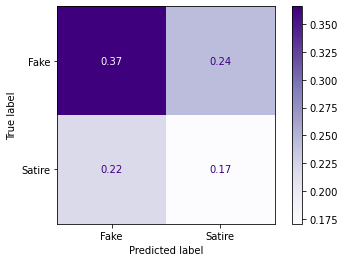

In [7]:
# Initialize and train dummy classifier
dummy_clf = DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_STATE
    ).fit(X_train, y_train)

# Get model quality metrics
y_pred_dummy = dummy_clf.predict(X_test)
get_model_scores(y_test, y_pred_dummy, label=POS_LABEL)
plot_confusion_matrix(y_test, y_pred_dummy, dummy_clf.classes_)

###<b>LR with Text</b>

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

        Fake       0.73      0.90      0.80        50
      Satire       0.75      0.47      0.58        32

    accuracy                           0.73        82
   macro avg       0.74      0.68      0.69        82
weighted avg       0.74      0.73      0.72        82


OVERALL MODEL SCORES:
F1 Score: 0.5769230769230769
Accuracy: 0.7317073170731707




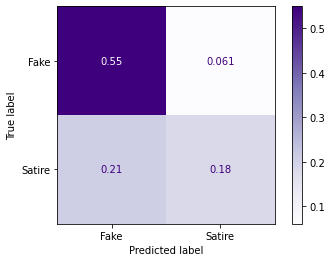

In [8]:
# TfIdf vectorizer on article text (body of article only)
vectorizer = TfidfVectorizer(
    min_df=MIN_DF,
    max_df=MAX_DF, 
    stop_words=STOP_WORDS, 
    ngram_range=(1,3)
    )
X_train_text = vectorizer.fit_transform(X_train['text'].values.astype('U'))
X_test_text = vectorizer.transform(X_test['text'].values.astype('U'))

# Initialize, train, and score logistic regression model
lr_clf_text = model_predict_score(X_train_text, X_test_text, y_train)

###<b>LR with Text + Title</b>

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

        Fake       0.80      0.86      0.83        50
      Satire       0.75      0.66      0.70        32

    accuracy                           0.78        82
   macro avg       0.77      0.76      0.76        82
weighted avg       0.78      0.78      0.78        82


OVERALL MODEL SCORES:
F1 Score: 0.7
Accuracy: 0.7804878048780488




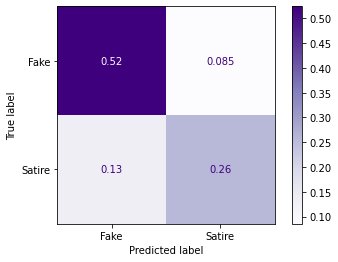

In [9]:
# TfIdf vectorizer - add title feature
title_vectorizer = TfidfVectorizer(
    min_df=MIN_DF,
    max_df=MAX_DF, 
    stop_words=STOP_WORDS, 
    ngram_range=(1,3)
    )
X_train_title = title_vectorizer.fit_transform(X_train['title'].values.astype('U'))
X_test_title = title_vectorizer.transform(X_test['title'].values.astype('U'))

X_train_tfidf = sparse.hstack([X_train_text, X_train_title])
X_test_tfidf = sparse.hstack([X_test_text, X_test_title])

# Initialize, train, and score logistic regression model
lr_clf_title_text = model_predict_score(X_train_tfidf, X_test_tfidf, y_train)

###<b>LR with Text + Title + Punctuation</b>

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

        Fake       0.79      0.82      0.80        50
      Satire       0.70      0.66      0.68        32

    accuracy                           0.76        82
   macro avg       0.74      0.74      0.74        82
weighted avg       0.75      0.76      0.75        82


OVERALL MODEL SCORES:
F1 Score: 0.6774193548387096
Accuracy: 0.7560975609756098




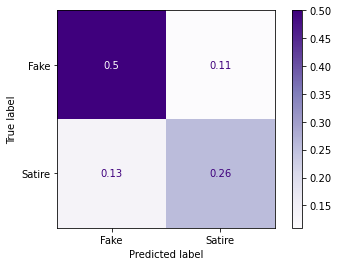

In [10]:
# Get punctuation features
X_train_punct = count_punctuation(X_train)
X_test_punct = count_punctuation(X_test)

# Only keep punctuation features that exist in both train and test sets
keep_cols = list(set(X_train_punct.columns) & set(X_test_punct.columns))
X_train_punct = X_train_punct[keep_cols]
X_test_punct = X_test_punct[keep_cols]

# Merge punctuation features into vectorized sparse matrices
X_train_all = merge_features(X_train_tfidf, X_train_punct)
X_test_all = merge_features(X_test_tfidf, X_test_punct)

# Initialize, train, and score logistic regression model
lr_clf_all = model_predict_score(X_train_all, X_test_all, y_train)

###<b>Feature Importance</b>

In [11]:
# Show feature importance
features_list = list(vectorizer.get_feature_names_out())
features_list.extend(list(title_vectorizer.get_feature_names_out()))
features_list.extend(keep_cols)

In [92]:
weights_df, feat_importance_plot = explain_pred(
    features=features_list, 
    train_array=X_train_all, 
    clf_lr=lr_clf_all, 
    num_top_feats=20
    )

feat_importance_plot

<ipython-input-43-30a51e833c28>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weights_df_trimmed['Labels'] = weights_df_trimmed['LR Weights'].apply(


alt.Chart(...)

###<b>ScatterText Plot</b>

In [93]:
# Specify terms to label in plot
term_list = [
    'breaking', '"', 'dead', 'war', 'like', 'awards',
    'many', 'one', 'biblical', 'washington', 'administration',
    'woman', 'found dead', 'shows', '-', 'russia', 'power', 
    'hospital', 'brexit', 'body'
    ]

# Start with the raw Golbeck text
text_df = golbeck_df[['title', 'text', 'label']]
text_df['text'] = golbeck_df['title'] + ' ' + golbeck_df['text']
scatter_df = text_df.assign(
    parse=lambda text_df: text_df.text.apply(
        st.whitespace_nlp_with_sentences
        )
    )

corpus = st.CorpusFromParsedDocuments(
    scatter_df,
    category_col='label',
    parsed_col='parse'
).build().get_unigram_corpus().compact(
    st.AssociationCompactor(2000)
    )

# Generate the scatter plot data
scatter_data = st.produce_scattertext_explorer(
    corpus,
    category='Satire', 
    category_name='Satire', 
    not_category_name='Fake',
    minimum_term_frequency=0, 
    pmi_threshold_coefficient=0,
    return_data=True,
    transform=st.Scalers.dense_rank
)

# Put it into a dataframe and plot the points with text
scatter_plot_df = pd.DataFrame(scatter_data['data'])

# Filter out areas of scattertext plot with no important LR features
scatter_plot_df = scatter_plot_df[scatter_plot_df['x'] < 0.7]
scatter_plot_df = scatter_plot_df[scatter_plot_df['y'] < 0.7]
scatter_plot_df['plot_term'] = scatter_plot_df['term'].apply(
    lambda x: x if x in term_list else ' '
    )

scatter_plot = alt.Chart(scatter_plot_df).mark_circle().encode(
    x = alt.X(
        'x:Q', 
        title='\u21e6 less with satire | more with satire \u21e8',
        axis=alt.Axis(tickMinStep=0.1)
        ),
        y = alt.Y(
            'y:Q', 
            title='\u21e6 less with fake | more with fake \u21e8', 
            axis=alt.Axis(tickMinStep=0.1)
            ),
            color = alt.Color(
                's', 
                scale=alt.Scale(
                    scheme='redyellowgreen', 
                    reverse=True
                    ),
                    legend=alt.Legend(
                        title=["Satire vs Fake", "frequency"]
                        )
                    )
            ).properties(
                width = 500,
                height = 500
                )

text = alt.Chart(scatter_plot_df).mark_text(
    align='left',
    baseline='middle',
    dx=7,
    color='black'
).encode(
    x = alt.X('x:Q'),
    y = alt.Y('y:Q'),
    text='plot_term'
).properties(
    title = 'How frequently are terms used with each type of news?',
    width = 500,
    height = 500
)

(scatter_plot + text).configure_axis(
    labelFontSize=10,
    titleFontSize=12
).configure_title(
    fontSize=15,
    anchor='start'
).configure_legend(
    titleFontSize=12
)

<ipython-input-93-2cc87b8449fe>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['text'] = golbeck_df['title'] + ' ' + golbeck_df['text']


alt.LayerChart(...)